In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from tensorflow.keras.layers import Dense,Conv2D,Conv2DTranspose,BatchNormalization,Input,ReLU,Add,Flatten,Dropout,MaxPool2D
from tensorflow.keras.models import Model
from tensorflow import Tensor
from tensorflow.keras.models import load_model
import keras
import tensorflow as tf
from keras import backend as K

In [ ]:
from tensorflow.keras.datasets import mnist

In [ ]:
(x_train,y_train),(x_test,y_test)= mnist.load_data()

1.0
0.0


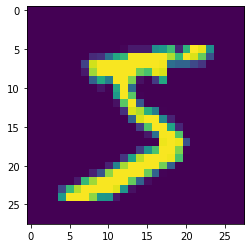

In [ ]:
x_train = x_train/255
x_train =x_train.reshape(-1,28,28,1)

x_test = x_test/255
x_test =x_test.reshape(-1,28,28,1)


print(x_train.max())
print(x_train.min())

plt.imshow(x_train[0].reshape(1,28,28)[0])

numpy.float64

In [ ]:
class PrintLayer(tf.keras.layers.Layer):
  def __init__(self):
      super(PrintLayer, self).__init__()
  def call(self,x):
    print(x.shape)
    return(x)

In [ ]:
class Encoder(keras.Model):
    def __init__(self):
        super(Encoder, self).__init__()


        self.flatten = Flatten(name='Flatten')
        self.dense1 = Dense(units=512,activation='relu',name='Dense1')
        self.printl= PrintLayer()
        self.dense2 = Dense(units=512,activation='relu',name='Dense2')
        self.mu = Dense( units = 20,activation='linear',name='Output_Mu')
        self.sigma = Dense( units = 20,activation='linear',name='Output_Sigma')
    def sample_z(self,mu,sigma):
      batch_size = mu.shape[0]
      rand = tf.random.normal(shape=(1,20))
      return(mu+K.exp(sigma*0.5)*rand)


    def call(self,x):
      #x=self.printl(x)
      x= self.flatten(x)
      #x=self.printl(x)
      x= self.dense1(x)
      #x=self.printl(x)
      x= self.dense2(x)
      #x=self.printl(x)
      
      mu = self.mu(x)
      sigma = self.sigma(x)
      sample_z = self.sample_z(mu,sigma)
      return(mu,sigma,sample_z)

    

In [ ]:
def get_decoder():
  inputs = Input(shape=(20))
  x =Dense(units=512,activation='relu')(inputs)
  x = Dense(units=512,activation='relu')(x)
  x = Dense( units =28*28,activation='sigmoid')(x)
  x = tf.keras.layers.Reshape((28,28))(x)
  model =Model(inputs,x)
  return(model)

In [ ]:
decoder = get_decoder()
decoder.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 20)]              0         
_________________________________________________________________
dense_78 (Dense)             (None, 50)                1050      
_________________________________________________________________
dense_79 (Dense)             (None, 100)               5100      
_________________________________________________________________
dense_80 (Dense)             (None, 784)               79184     
_________________________________________________________________
reshape_15 (Reshape)         (None, 28, 28)            0         
Total params: 85,334
Trainable params: 85,334
Non-trainable params: 0
_________________________________________________________________


#LOSS

In [ ]:


def reg_loss_fn(mu,sigma):
  reg_loss = 0.5 * K.sum(K.exp(sigma) + K.square(mu) - 1. - sigma, axis=-1)

  return (reg_loss)


# MODEL

In [ ]:
class VAE(keras.Model):
    def __init__(
        self,
        encoder,
        decoder,
    ):
        super(VAE, self).__init__()
        self.encoder=encoder,
        self.decoder=decoder

    def compile(
        self,
        encoder_optimizer,
        decoder_optimizer,
        loss_recon_fn,
        loss_reg_fn,
        
    ):
        super(VAE, self).compile()
        self.encoder_optimizer = encoder_optimizer
        self.decoder_optimizer = decoder_optimizer
        self.loss_recon_fn = loss_recon_fn
        self.loss_reg_fn = loss_reg_fn
        

    def train_step(self, batch_data):
        real_images= batch_data
        with tf.GradientTape(persistent=True) as tape:
            mu,sigma,z_sample = encoder(real_images)
            reconstructed_images = decoder(z_sample)
        

            loss_recon = self.loss_recon_fn(real_images,reconstructed_images)
            loss_reg = self.loss_reg_fn(mu,sigma)
            loss =  loss_recon+loss_reg

            

        grads_encoder = tape.gradient(loss, self.encoder.trainable_variables)
        grads_decoder = tape.gradient(loss, self.decoder.trainable_variables)

    

        self.encoder_optimizer.apply_gradients(
            zip(grads_encoder, self.encoder.trainable_variables)
        )
        self.decoder_optimizer.apply_gradients(
            zip(grads_decoder, self.decoder.trainable_variables)
        )

     

        return {
            "Reconstruction_loss": loss_recon,
            "KL_loss": loss_reg,
            "Total_loss": loss,
        }

In [ ]:
encoder = Encoder()
decoder = get_decoder()

vae = VAE(
    encoder=encoder, decoder=decoder
)

vae.compile(
    encoder_optimizer=keras.optimizers.Adam(learning_rate =0.001),
    decoder_optimizer=keras.optimizers.Adam(learning_rate =0.001),
    loss_recon_fn= tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.SUM),

    loss_reg_fn=reg_loss_fn,
)

In [ ]:
vae.fit(
    x=x_train,
    epochs=80,
)

Epoch 1/80
1875/1875 [==============================] - 10s 5ms/step - Reconstruction_loss: 159.1609 - KL_loss: 14.1557 - Total_loss: 173.3165
Epoch 2/80
1875/1875 [==============================] - 9s 5ms/step - Reconstruction_loss: 116.5552 - KL_loss: 19.1505 - Total_loss: 135.7057
Epoch 3/80
1875/1875 [==============================] - 9s 5ms/step - Reconstruction_loss: 106.9244 - KL_loss: 20.4546 - Total_loss: 127.3790
Epoch 4/80
1026/1875 [===============>..............] - ETA: 4s - Reconstruction_loss: 103.7747 - KL_loss: 20.8180 - Total_loss: 124.5927

KeyboardInterrupt: ignored

#TEST  MLP


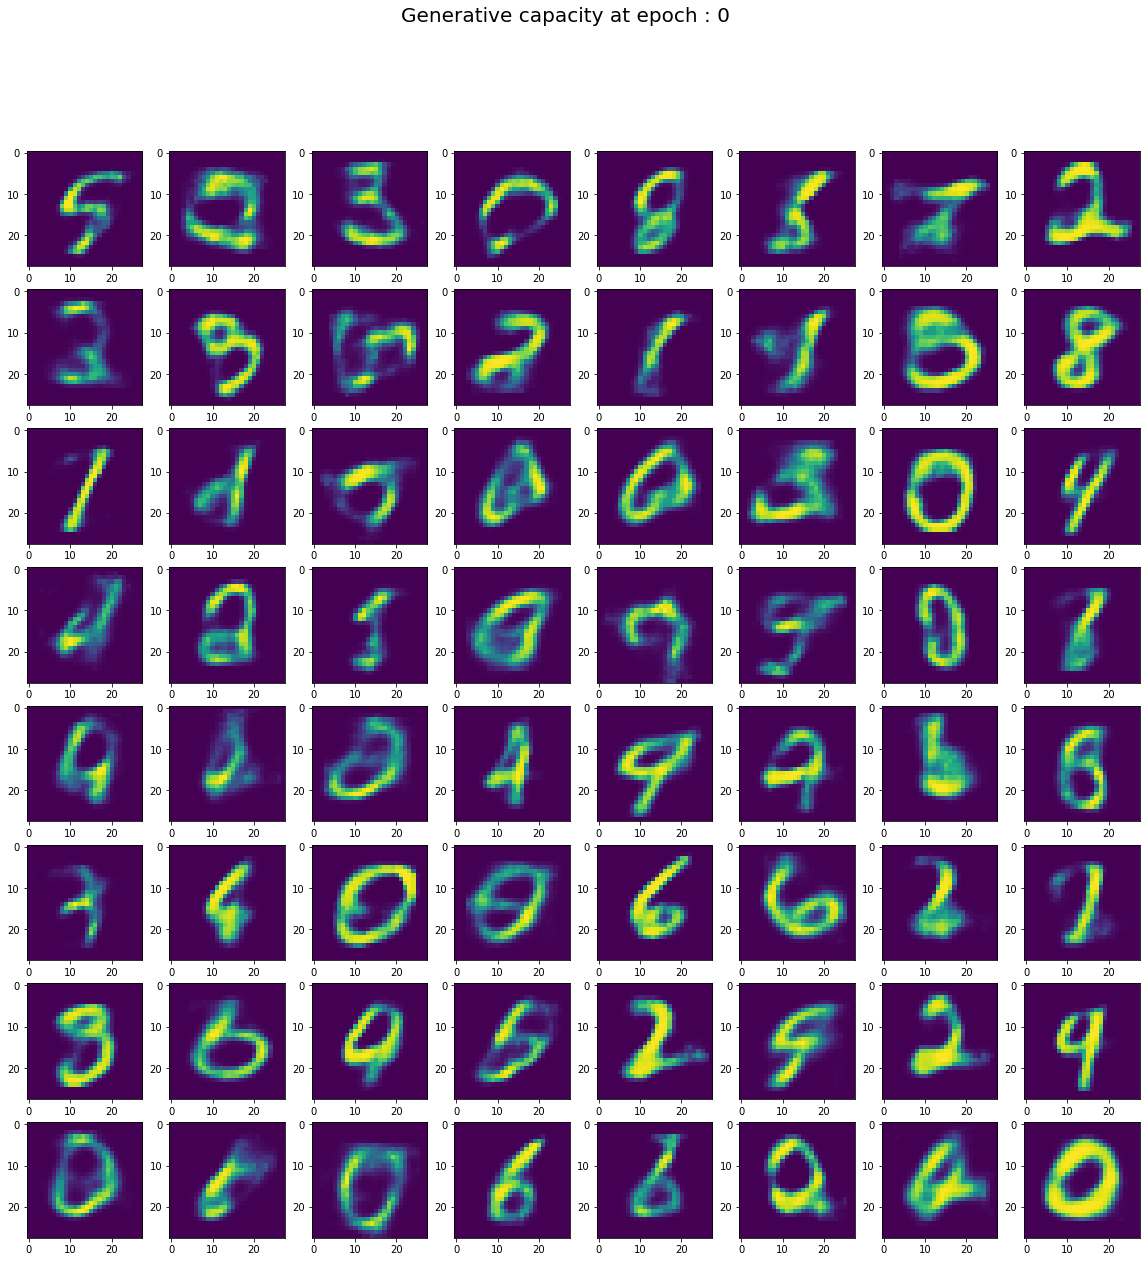

In [ ]:
plt.figure(figsize=(20,20))
plt.suptitle("Generative capacity at epoch : 0",  fontsize=20)

for i in range(1,65):

  code = np.random.normal(size=(1,20))
  decode = decoder(code)
  decode =np.array(decode).reshape(1,28,28)[0]
  plt.subplot(8,8,i)
  plt.imshow(decode)

# UNET MODEL

In [ ]:
k_initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02, seed=None)

class EncoderUnet(keras.Model):
    def __init__(self):
        super(EncoderUnet, self).__init__()

        self.conv11 = Conv2D(filters=32,kernel_size=(3,3),padding='same',strides=(1,1),kernel_initializer=k_initializer)
        self.BN11 = BatchNormalization()
        self.relu11 =ReLU()

        self.conv12 = Conv2D(filters=32,kernel_size=(3,3),padding='same',strides=(1,1),kernel_initializer=k_initializer)
        self.BN12 = BatchNormalization()
        self.relu12=ReLU()

        self.maxpool1= MaxPool2D(pool_size=(2,2),strides=(2,2),padding='same')

        self.conv21 = Conv2D(filters=64,kernel_size=(3,3),padding='same',strides=(1,1),kernel_initializer=k_initializer)
        self.BN21 = BatchNormalization()
        self.relu21=ReLU()

        self.conv22 = Conv2D(filters=64,kernel_size=(3,3),padding='same',strides=(1,1),kernel_initializer=k_initializer)
        self.BN22 = BatchNormalization()
        self.relu22=ReLU()

        self.maxpool2= MaxPool2D(pool_size=(2,2),strides=(2,2),padding='same')

        self.conv31 = Conv2D(filters=64,kernel_size=(3,3),padding='same',strides=(1,1),kernel_initializer=k_initializer)
        self.BN31 = BatchNormalization()
        self.relu31=ReLU()
        
        self.dense1= Dense(units=32,activation='relu')

  
        self.flatten = Flatten()

        self.mu = Dense( units = 20,activation='linear',name='Output_Mu')
        self.sigma = Dense( units = 20,activation='linear',name='Output_Sigma')


    def sample_z(self,mu,sigma):
      batch_size = mu.shape[0]
      rand = tf.random.normal(shape=(1,20))
      return(mu+K.exp(sigma*0.5)*rand)


    def call(self,x):

      x = self.conv11(x)
      x= self.BN11(x)
      x= self.relu11(x)
      x = self.conv12(x)
      x =self.BN12(x)
      x= self.relu12(x)
      x= self.maxpool1(x)

      x = self.conv21(x)
      x= self.BN21(x)
      x= self.relu21(x)
      x = self.conv22(x)
      x =self.BN22(x)
      x= self.relu22(x)
      x= self.maxpool2(x)

      x = self.conv31(x)
      x= self.BN31(x)
      x= self.relu31(x)
      
      x = self.flatten(x)

      x=self.dense1(x)
      
      mu = self.mu(x)
      sigma = self.sigma(x)
      sample_z = self.sample_z(mu,sigma)
      return(mu,sigma,sample_z)

    

def get_decoder_Unet():
  inputs = Input(shape=(20))
  x =Dense(units=7*7*64,activation='relu')(inputs)
  x = tf.keras.layers.Reshape((7,7,64))(x)

  x=Conv2D(filters=64, kernel_size=(3,3),strides=(1,1),padding='same')(x)
  x=BatchNormalization()(x)
  x=ReLU()(x)

  x=Conv2DTranspose(filters=64,kernel_size=(2,2),strides=(2,2),padding='valid',name='UPSAMPLE1',kernel_initializer=k_initializer)(x)
  
  x=Conv2D(filters=64, kernel_size=(3,3),strides=(1,1),padding='same',kernel_initializer=k_initializer)(x)
  x=BatchNormalization()(x)
  x=ReLU()(x)

  x=Conv2D(filters=64, kernel_size=(3,3),strides=(1,1),padding='same',kernel_initializer=k_initializer)(x)
  x=BatchNormalization()(x)
  x=ReLU()(x)

  x=Conv2DTranspose(filters=32,kernel_size=(2,2),strides=(2,2),padding='valid',name='UPSAMPLE2',kernel_initializer=k_initializer)(x)
  
  x=Conv2D(filters=32, kernel_size=(3,3),strides=(1,1),padding='same',kernel_initializer=k_initializer)(x)
  x=BatchNormalization()(x)
  x=ReLU()(x)

  x=Conv2D(filters=32, kernel_size=(3,3),strides=(1,1),padding='same',kernel_initializer=k_initializer)(x)
  x=BatchNormalization()(x)
  x=ReLU()(x)

  x=Conv2D(filters=1, kernel_size=(3,3),strides=(1,1),padding='same',activation='sigmoid',kernel_initializer=k_initializer)(x)

  model =Model(inputs,x)
  return(model)

In [ ]:
encoder = EncoderUnet()
decoder = get_decoder_Unet()

vae_unet = VAE(
    encoder=encoder, decoder=decoder
)

vae_unet.compile(
    encoder_optimizer=keras.optimizers.Adam(learning_rate =0.001),
    decoder_optimizer=keras.optimizers.Adam(learning_rate =0.001),
    loss_recon_fn= tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.SUM),
    loss_reg_fn=reg_loss_fn,
)

In [ ]:
decoder.summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 20)]              0         
_________________________________________________________________
dense_25 (Dense)             (None, 49)                1029      
_________________________________________________________________
reshape_19 (Reshape)         (None, 7, 7, 1)           0         
_________________________________________________________________
UPSAMPLE1 (Conv2DTranspose)  (None, 14, 14, 64)        320       
_________________________________________________________________
re_lu_156 (ReLU)             (None, 14, 14, 64)        0         
_________________________________________________________________
UPSAMPLE2 (Conv2DTranspose)  (None, 28, 28, 32)        8224      
_________________________________________________________________
re_lu_157 (ReLU)             (None, 28, 28, 32)        0  

In [ ]:
vae_unet.fit(
    x=x_train,
    epochs=80,
  
)

Epoch 1/80
1875/1875 [==============================] - 54s 28ms/step - Reconstruction_loss: 4737.5515 - KL_loss: 54.1996 - Total_loss: 4791.7500
Epoch 2/80
1875/1875 [==============================] - 52s 28ms/step - Reconstruction_loss: 3461.4899 - KL_loss: 61.5042 - Total_loss: 3522.9939
Epoch 3/80
1875/1875 [==============================] - 52s 28ms/step - Reconstruction_loss: 3339.9095 - KL_loss: 62.0254 - Total_loss: 3401.9341
Epoch 4/80
1875/1875 [==============================] - 52s 28ms/step - Reconstruction_loss: 3264.3450 - KL_loss: 61.9440 - Total_loss: 3326.2888
Epoch 5/80
1875/1875 [==============================] - 52s 28ms/step - Reconstruction_loss: 3215.9710 - KL_loss: 61.3289 - Total_loss: 3277.3000
Epoch 6/80
1875/1875 [==============================] - 52s 28ms/step - Reconstruction_loss: 3177.3163 - KL_loss: 61.0028 - Total_loss: 3238.3196
Epoch 7/80
1875/1875 [==============================] - 52s 28ms/step - Reconstruction_loss: 3145.9342 - KL_loss: 60.3836 - 

# TEST UNET



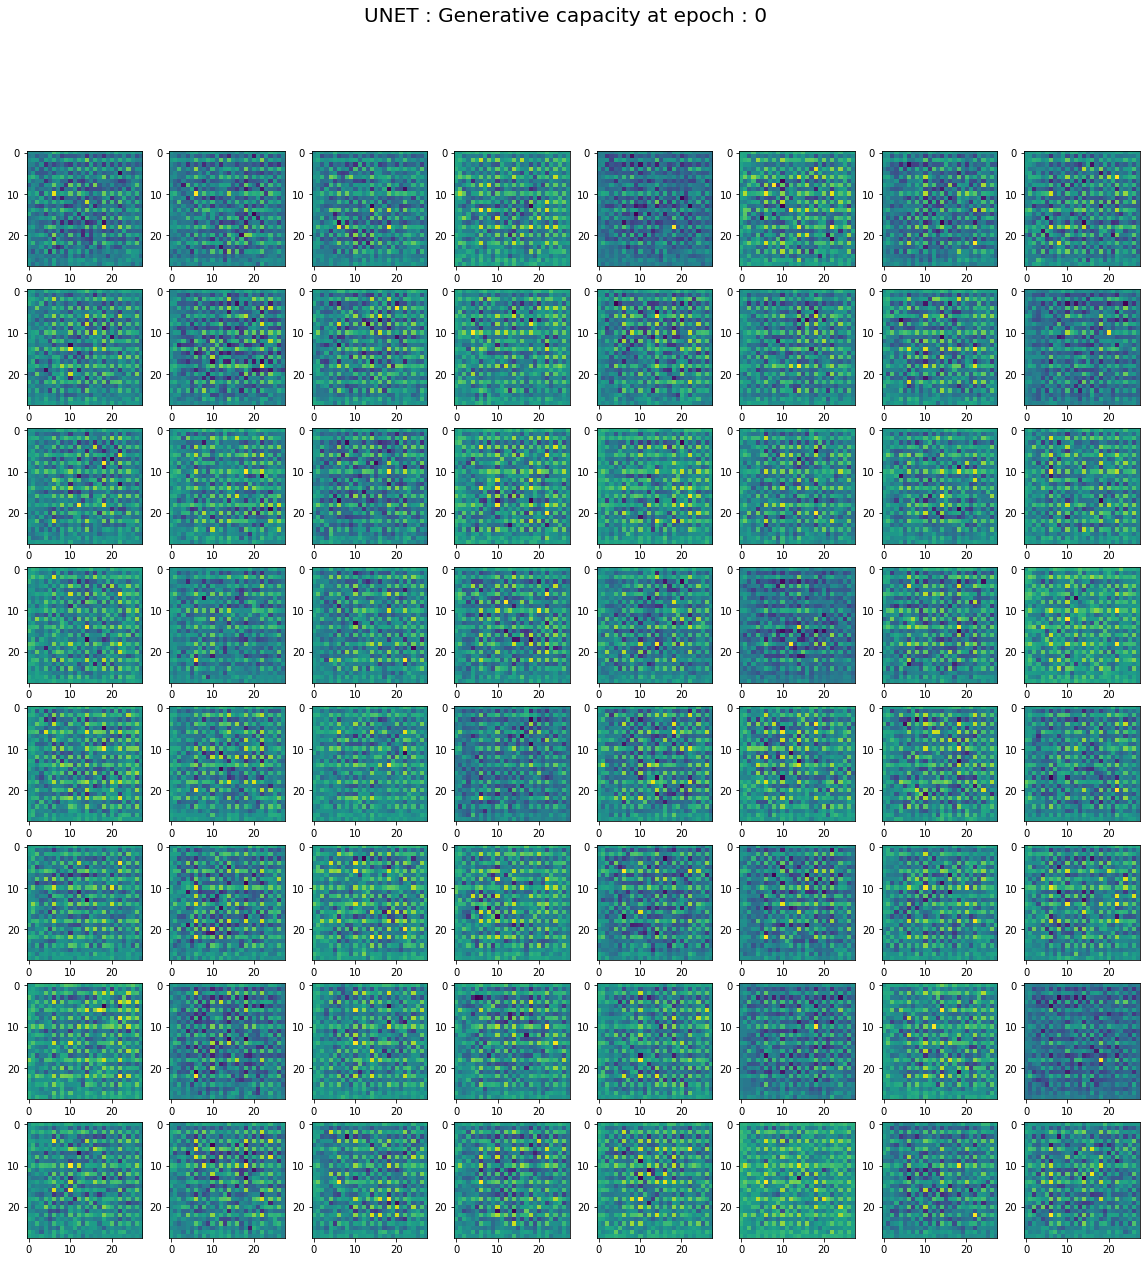

In [ ]:
plt.figure(figsize=(20,20))
plt.suptitle("UNET : Generative capacity at epoch : 0",  fontsize=20)

for i in range(1,65):

  code = np.random.normal(size=(1,20))
  decode = decoder(code)
  decode =np.array(decode).reshape(1,28,28)[0]
  plt.subplot(8,8,i)
  plt.imshow(decode)